# Predicting Cognitive Decline using Neuroimaging Biomarkers in Healthy Older Adults from the Knight ADRC

## Introduction

Accumulation of ß-amyloid (Aß)plaques, tau-containing neurofibrillary tangles, and progressive neuronal atrophy are the hallmark neuroanatomical biomarkers of Alzheimer Disease (AD), and these progressive changes emerge up to two decades prior to decline in cognition. Following the Aß, tau, and neurodegenerative (ATN) framework, we will investigate the relationship between AD biomarkers and cognitive decline in healthy older adults from the Charles F. and Joanne Knight Alzheimer Disease Research Center (Knight ADRC).

Participants selected for this study were cognitively unimpaired at time of study enrollment and were required to have completed one PiB-positron emission tomography (PET) and magnetic resonance (MR) imaging session, and two cognitive visits. Participants were further separated into those that remained cognitively stable and those that showed cognitive decline.  

The purpose of this project is to determine whether or not biological markers of AD are predictive of cognitive decline. 

## The Data Analysis Pipeline 

### 1. Data: OASIS and ADNI
Data were provided by the Open Access Series of Imaging Studies (OASIS) and the Alzheimer Disease Neuroimaging Initiative (ADNI). Cleaning, merging, and preprocessing were completed using RStudio v1.3.1093. R-files can be found at https://github.com/dianahobbs/DS-SupervisedLearning.

These datasets includes metrics for age, sex, education, race, APOE ε4 status, PET- (amyloid measured in centiloid values) and MR-Imaging (brain volume and thickness), and cognition in older adults that are cognitively unimpaired at baseline. Using this data, I will build a model that will learn from this data to predict individuals that present cognitive decline based on different biomarkers for AD.

#### Import Libraries and Download the Data

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Graph within notebook
%matplotlib inline 

# Set up matplotlib
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set a random seed
np.random.seed(42)

# Load the data
df = pd.read_csv(r'./Data/data_for_python.csv')

### 2. Data Exploration & Wrangling 
At this stage of the process, it is beneficial to visually explore the data to get a general idea of correlations and patterns. 

#### Preliminary Look at the Data

In [2]:
# What are the column headings 
print("df.keys():\n", df.keys())
df.head()

df.keys():
 Index(['ID', 'AGE', 'SEX', 'EDUC', 'RACE', 'BMI', 'APOE4', 'percenthipp',
       'thick', 'centiloid', 'Cog_Convert', 'followuptime', 'biomarker_group'],
      dtype='object')


,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
0,21,79.562543,Female,18,non-White,31.455775,0,0.561073,2.993750,22.518400,0,0.989747,2
1,23,79.866029,Male,14,non-White,27.799961,0,0.502151,2.779375,26.394551,0,0.992481,1
2,89,71.756664,Male,20,White,27.028939,0,0.494580,3.247375,4.111063,0,0.270677,4
3,257,85.850991,Female,6,White,21.494759,1,0.366224,2.585375,100.092846,0,0.133971,1
4,295,89.878332,Male,18,White,23.334203,1,0.402439,2.840750,86.823717,0,0.948735,2


In [3]:
df.tail()

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
455,31119,53.0,Male,16,White,26.757785,0,0.497850,3.129500,2.246167,0,4.084815,4
456,31125,71.0,Female,12,White,21.786092,0,0.533930,2.906375,-1.441793,0,8.462380,4
457,31158,67.0,Male,13,non-White,27.472922,0,0.576317,2.768625,1.687385,0,6.787962,3
458,31165,57.0,Male,12,White,26.283134,1,0.538159,2.947125,-8.258930,0,3.069767,4
459,31168,65.0,Male,16,White,24.952160,1,0.492719,2.947500,94.668663,0,6.911081,2


In [4]:
# Check missing data and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               460 non-null    int64  
 1   AGE              460 non-null    float64
 2   SEX              460 non-null    object 
 3   EDUC             460 non-null    int64  
 4   RACE             460 non-null    object 
 5   BMI              459 non-null    float64
 6   APOE4            460 non-null    int64  
 7   percenthipp      460 non-null    float64
 8   thick            460 non-null    float64
 9   centiloid        460 non-null    float64
 10  Cog_Convert      460 non-null    int64  
 11  followuptime     459 non-null    float64
 12  biomarker_group  460 non-null    int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 46.8+ KB


In [5]:
# Drop irrelevant columns: ID and followup time
df=df.drop("ID", axis=1)
df=df.drop("followuptime", axis=1)

##### The dataset shows the following information: 
- There are 460 observations, which is very small for machine learning standards.
- Attributes `SEX` and `RACE` are coded as categorical objects; these will need to be recoded as numerical.
- There is one instance missing in attribute `BMI`. 

##### Recode Variables with Text as Numeric

In [6]:
# How are sex and race coded in the data? 
print(f'Sex is coded as: \n{df["SEX"].value_counts()} \n')
print(f'Race is coded as: \n{df["RACE"].value_counts()} \n')

Sex is coded as: 
Female    256
Male      204
Name: SEX, dtype: int64 

Race is coded as: 
White        409
non-White     51
Name: RACE, dtype: int64 



In [7]:
# Recode sex and race as numberical
df["SEX"]=df["SEX"].replace(("Male","Female"),(0,1)) # Males: 0, Females: 1
df["RACE"]=df["RACE"].replace(("White","non-White"),(0,1)) # White: 0, non-White: 1
df.head()

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
0,79.562543,1,18,1,31.455775,0,0.561073,2.993750,22.518400,0,2
1,79.866029,0,14,1,27.799961,0,0.502151,2.779375,26.394551,0,1
2,71.756664,0,20,0,27.028939,0,0.494580,3.247375,4.111063,0,4
3,85.850991,1,6,0,21.494759,1,0.366224,2.585375,100.092846,0,1
4,89.878332,0,18,0,23.334203,1,0.402439,2.840750,86.823717,0,2


##### Address Missing Values 
We are going to check for missing data and use the median to fill in the missing `BMI` data. 

In [8]:
# Set incomplete rows as a variable to visualize
missingdata = df[df.isnull().any(axis=1)].head()
missingdata

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
145,70.930964,1,20,0,NaN,0,0.490153,2.97675,-0.57374,0,4


In [9]:
# Input median for missing BMI data
medianBMI=df["BMI"].median()
df["BMI"].fillna(medianBMI, inplace=True)
df

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
0,79.562543,1,18,1,31.455775,0,0.561073,2.993750,22.518400,0,2
1,79.866029,0,14,1,27.799961,0,0.502151,2.779375,26.394551,0,1
2,71.756664,0,20,0,27.028939,0,0.494580,3.247375,4.111063,0,4
3,85.850991,1,6,0,21.494759,1,0.366224,2.585375,100.092846,0,1
4,89.878332,0,18,0,23.334203,1,0.402439,2.840750,86.823717,0,2
...,...,...,...,...,...,...,...,...,...,...,...
455,53.000000,0,16,0,26.757785,0,0.497850,3.129500,2.246167,0,4
456,71.000000,1,12,0,21.786092,0,0.533930,2.906375,-1.441793,0,4
457,67.000000,0,13,1,27.472922,0,0.576317,2.768625,1.687385,0,3
458,57.000000,0,12,0,26.283134,1,0.538159,2.947125,-8.258930,0,4


##### Descriptive Statistics 

In [10]:
df.describe()

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,70.287426,0.556522,16.391304,0.110870,27.744840,0.308696,0.520465,2.921242,21.122330,0.130435,3.156522
std,8.534873,0.497336,2.575046,0.314312,5.114645,0.462458,0.066774,0.156484,34.435242,0.337148,1.029764
min,43.000000,0.000000,6.000000,0.000000,18.469349,0.000000,0.366224,2.364375,-54.322183,0.000000,1.000000
25%,66.000000,0.000000,15.000000,0.000000,24.454782,0.000000,0.475588,2.822594,-1.357975,0.000000,2.000000
50%,70.755981,1.000000,16.000000,0.000000,26.679264,0.000000,0.516369,2.924625,7.967646,0.000000,4.000000
75%,75.755297,1.000000,18.000000,0.000000,30.350620,1.000000,0.565604,3.026031,31.573660,0.000000,4.000000
max,93.894737,1.000000,20.000000,1.000000,57.742001,1.000000,0.833345,3.418625,158.034123,1.000000,4.000000


By comparing the 75% percentile to the max, we see that the attribute `centiloid` potentially contains outliers. It may be beneficial to transform our data so our machine learning algorithm may more easily detect patterns. 

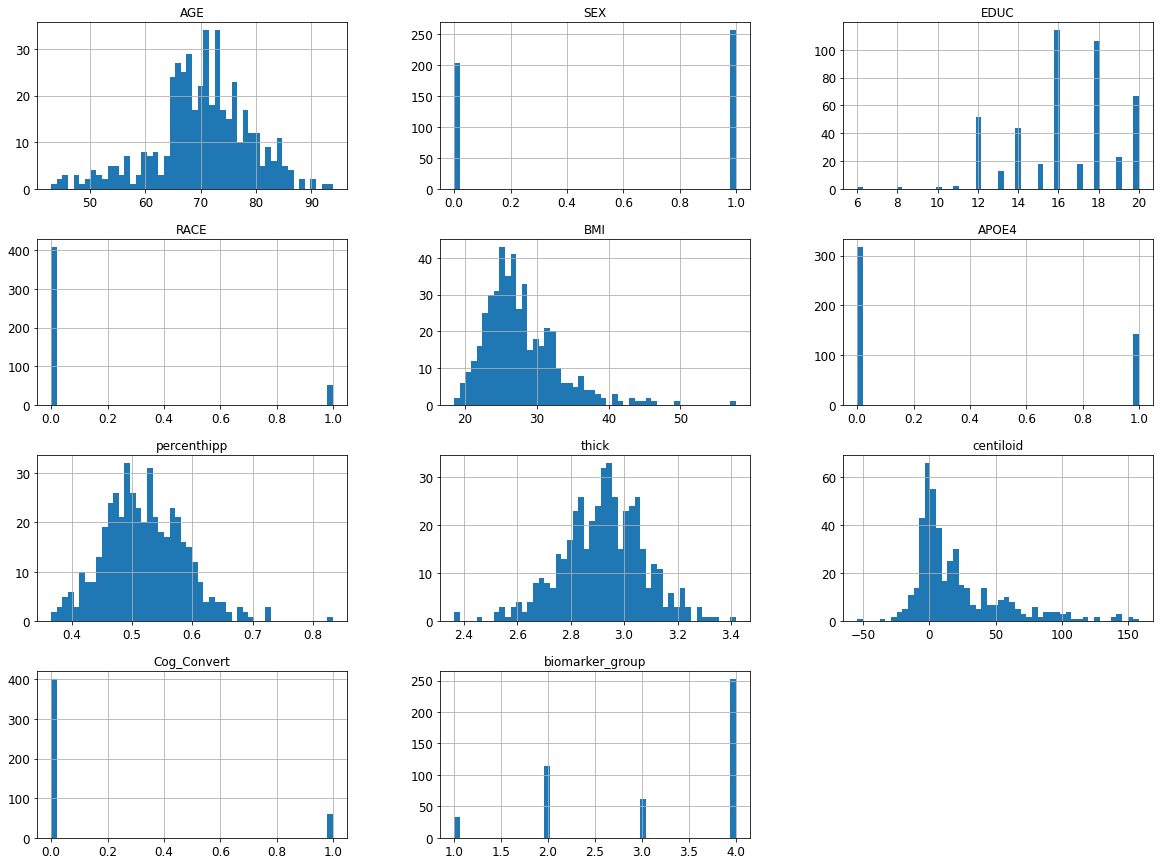

In [11]:
# Histogram 
df.hist(bins=50, figsize=(20,15));

##### The histograms show the following information: 
- The attribute `centiloid` is negatively skewed, which explains why our descriptive statistics were indicating the possibility of outliers. This does make sense conceptually as greater centiloid values are indiciative of greater Aß plaque deposition, and our participants were required to be cognitively unimpaired at baseline. 
- The attributes `AGE` and `EDUC` are positively skewed. This makes sense as an older population is more likely to have greater levels of education. 
- Finally, the scales of this data are not consistent with one another so we will do a transformation analysis later on. 

#### Create a Training and a Test Set

To minimize bias by data snooping, we will split our dataset into a training and a test set using the stratified sampling method. We decided to do this because our dataset is small for machine learning standards, and our data is highly imbalanced, especially in regard to our outcome variable: cognitive conversion. 

Because the neuroanatomical biomarkers are important attributes in predicting cognitive decline, we want to make sure the test set is representative of the different categories: A+N+, A+N-, A-N+, A-N-. 

In [12]:
# Split the training and test set such that both contain the same percentages 
from sklearn.model_selection import StratifiedShuffleSplit

shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in shuffle_split.split(df, df["biomarker_group"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [13]:
strat_train_set.head()

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
359,64.000000,1,12,0,27.432362,0,0.506601,3.043750,-6.135559,0,4
217,72.812030,1,18,0,22.432736,0,0.499787,2.899750,-3.517371,0,4
182,71.901572,1,14,0,29.081298,1,0.589041,3.024125,5.353254,0,4
56,72.645249,0,12,0,28.947059,0,0.447055,2.914875,9.661777,0,4
394,73.000000,0,16,0,35.436939,0,0.468094,2.696625,-0.883011,0,3


In [14]:
# Display the percentages for biomarker groups 
print('Percentages for income categories')
print('Stratified')
display(strat_test_set["biomarker_group"].value_counts() / len(strat_test_set))

# Check above against the original data
print('Original')
display(df["biomarker_group"].value_counts() / len(df))

Percentages for income categories
Stratified


4    0.543478
2    0.250000
3    0.130435
1    0.076087
Name: biomarker_group, dtype: float64

Original


4    0.547826
2    0.247826
3    0.132609
1    0.071739
Name: biomarker_group, dtype: float64

The percentages in both the original dataset and the split set are similar. Now we have a test set that we will keep separate until later.

#### More In-Depth Exploration of the Data: Training Set Only

First we will make a copy of the training set so we don't inadvertently change the training set. 

In [15]:
train_copy=strat_train_set.copy()

##### Data Visualization 

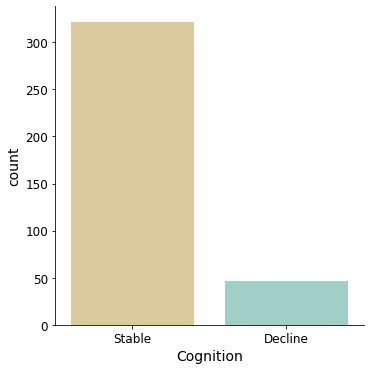

In [16]:
# Counts for cognitive converters vs non-converters 
fig1=sns.catplot(x="Cog_Convert", kind="count", palette="BrBG",data=train_copy)
fig1.set(xlabel="Cognition")
fig1.set_xticklabels(["Stable", "Decline"])
plt.show()

###### Categorical Variables

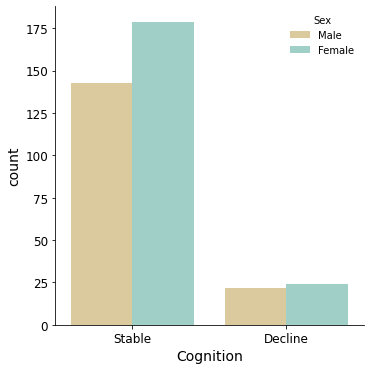

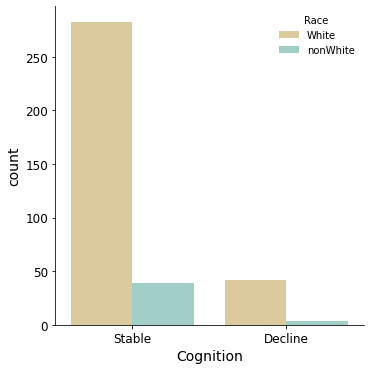

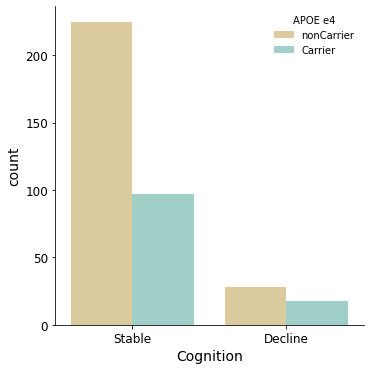

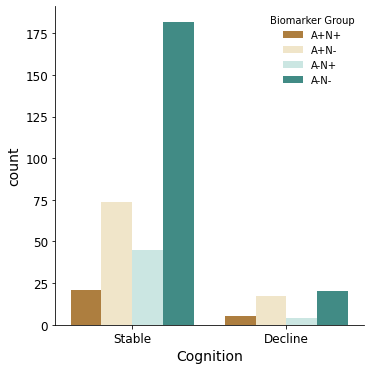

In [17]:
# Converters vs Sex
fig2=sns.catplot(x="Cog_Convert", hue="SEX", legend=False, palette="BrBG", kind="count", data=train_copy);
fig2.set(xlabel="Cognition")
fig2.set_xticklabels(["Stable", "Decline"])
plt.legend(title='Sex', loc='upper right', labels=['Male', 'Female'], frameon=False)
plt.show()

# Converters vs Race
fig3=sns.catplot(x="Cog_Convert", hue="RACE", legend=False, palette="BrBG", kind="count", data=train_copy);
fig3.set(xlabel="Cognition")
fig3.set_xticklabels(["Stable", "Decline"])
plt.legend(title='Race', loc='upper right', labels=['White', 'nonWhite'], frameon=False)
plt.show()

# Converters vs APOE e4 carriers 
fig4=sns.catplot(x="Cog_Convert", hue="APOE4", legend=False, palette="BrBG", kind="count", data=train_copy);
fig4.set(xlabel="Cognition")
fig4.set_xticklabels(["Stable", "Decline"])
plt.legend(title='APOE e4', loc='upper right', labels=['nonCarrier', 'Carrier'], frameon=False)
plt.show()

# Converters vs biomarker group 
fig5=sns.catplot(x="Cog_Convert", hue="biomarker_group", legend=False, palette="BrBG", kind="count", data=train_copy);
fig5.set(xlabel="Cognition")
fig5.set_xticklabels(["Stable", "Decline"])
plt.legend(title='Biomarker Group', loc='upper right', labels=['A+N+', 'A+N-','A-N+', 'A-N-'], frameon=False)
plt.show()

###### Continuous Variables

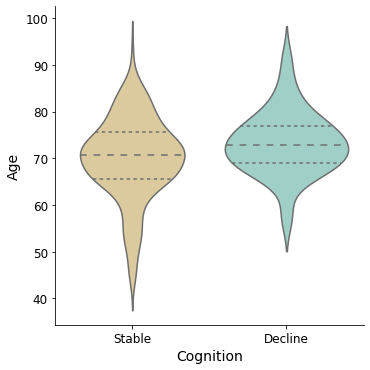

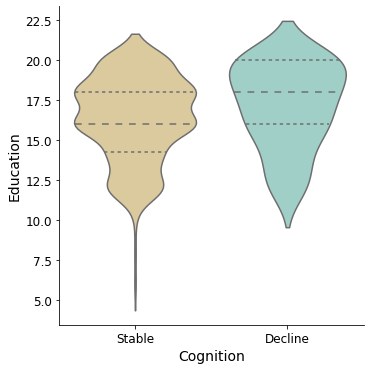

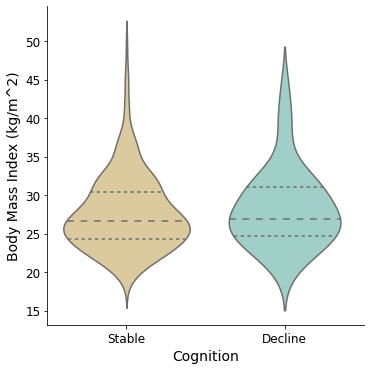

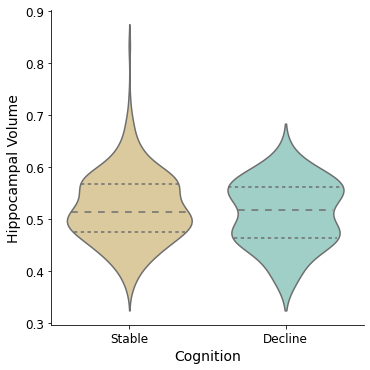

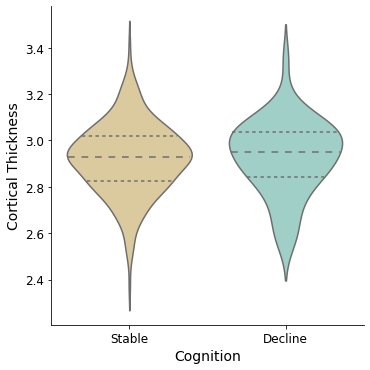

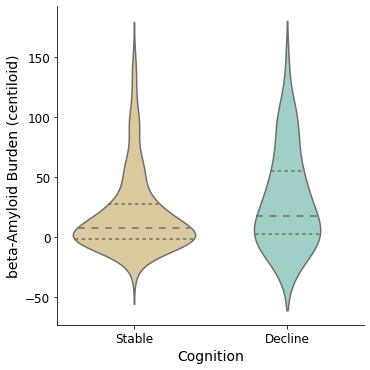

In [18]:
# Converters and Age
fig6=sns.catplot(x="Cog_Convert", y="AGE", legend=False, palette="BrBG", kind="violin", inner="quartile",data=train_copy);
fig6.set(xlabel="Cognition", ylabel="Age")
fig6.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Education 
fig7=sns.catplot(x="Cog_Convert", y="EDUC", legend=False, palette="BrBG", kind="violin", inner="quartile",data=train_copy);
fig7.set(xlabel="Cognition", ylabel="Education")
fig7.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and BMI 
fig8=sns.catplot(x="Cog_Convert", y="BMI", legend=False, palette="BrBG", kind="violin", inner="quartile",data=train_copy);
fig8.set(xlabel="Cognition", ylabel="Body Mass Index (kg/m^2)")
fig8.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Hippocampal Volume  
fig9=sns.catplot(x="Cog_Convert", y="percenthipp", legend=False, palette="BrBG", kind="violin", inner="quartile",data=train_copy);
fig9.set(xlabel="Cognition", ylabel="Hippocampal Volume")
fig9.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Cortical thickness 
fig10=sns.catplot(x="Cog_Convert", y="thick", legend=False, palette="BrBG", kind="violin", inner="quartile",data=train_copy);
fig10.set(xlabel="Cognition", ylabel="Cortical Thickness")
fig10.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Centiloid
fig10=sns.catplot(x="Cog_Convert", y="centiloid", legend=False, palette="BrBG", kind="violin", inner="quartile",data=train_copy);
fig10.set(xlabel="Cognition", ylabel="beta-Amyloid Burden (centiloid)")
fig10.set_xticklabels(["Stable", "Decline"])
plt.show()

Explore `AGE` and `centiloid` a little further. 

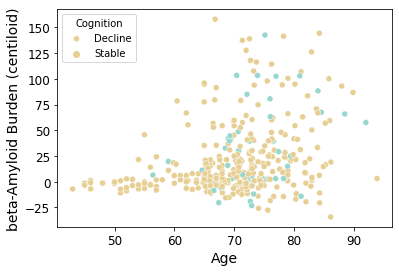

In [19]:
fig11=sns.scatterplot(x="AGE", y="centiloid", hue="Cog_Convert", palette="BrBG", data=train_copy)
fig11.set(xlabel="Age", ylabel="beta-Amyloid Burden (centiloid)")
fig11.legend(title="Cognition", labels=["Decline", "Stable"]);

As individuals age, you see greater centiloid levels indicating the accumulation of Aß plaques.

How do the other variable compare? A correlation matrix can show us this. 

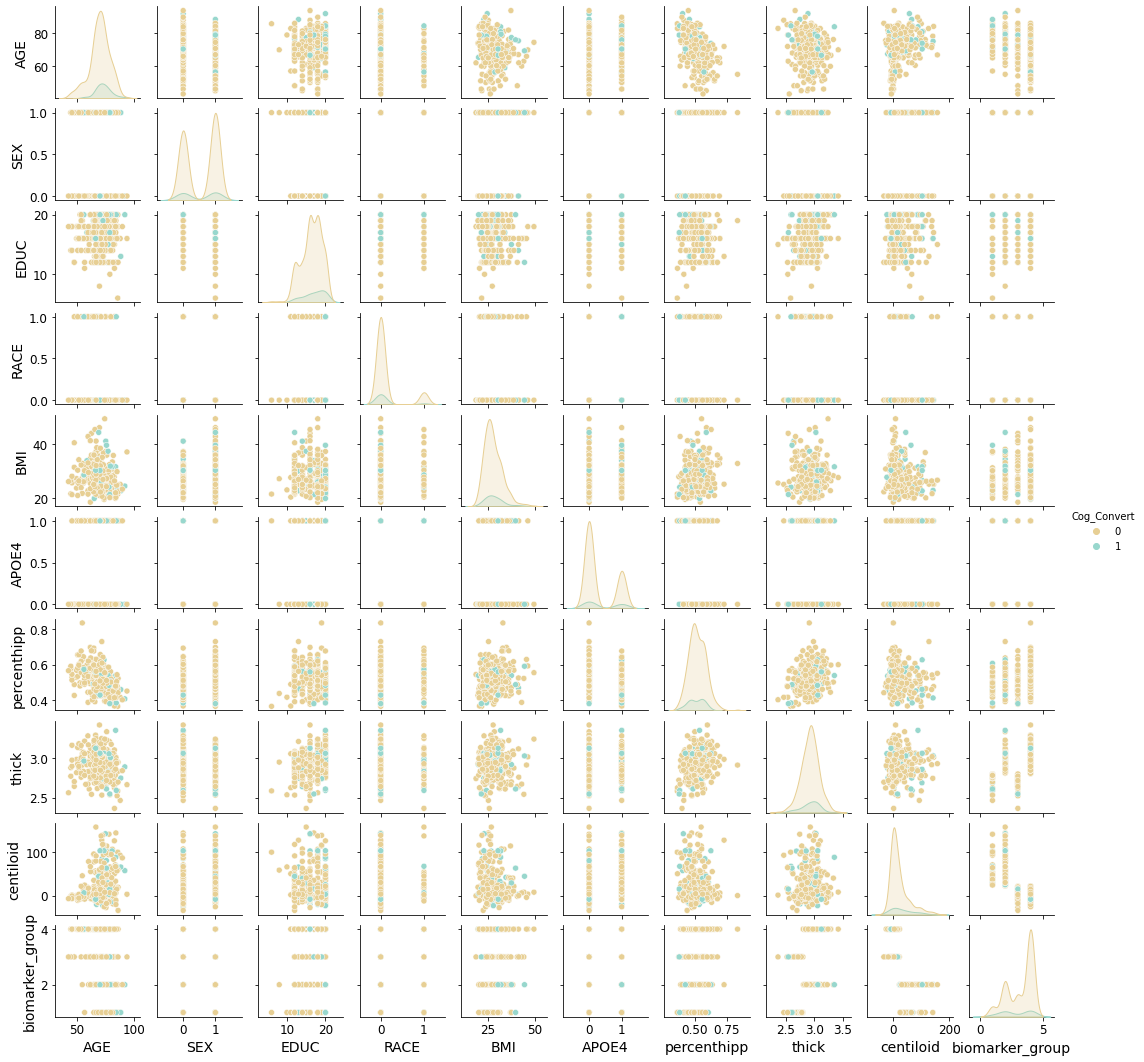

In [20]:
sns.pairplot(train_copy, hue="Cog_Convert", palette="BrBG", height=1.5);

In [21]:
# correlation matrix 
corr_matrix=train_copy.corr()
corr_matrix["Cog_Convert"].sort_values(ascending=False)

Cog_Convert        1.000000
AGE                0.125411
centiloid          0.108599
EDUC               0.096386
APOE4              0.064260
BMI                0.043222
thick              0.014963
SEX               -0.022717
RACE              -0.035170
percenthipp       -0.054637
biomarker_group   -0.115098
Name: Cog_Convert, dtype: float64

The strength of these correlations is pretty small. The correlation matrix above visualizes the relationships between our predictor variables. 

- `AGE` is negatively correlated with `percenthipp` and `thick`; positively related to `centiloid`. 
- `percenthipp` is positively correlated with `thick` and negatively correlated with `centiloid`. 
- `BMI` and `centiloid` look to be negatively correlated. 

It may make sense to combine some of these variables to potentially improve predictive ability. 

##### Feature Engineering: Experimenting with Attribute Combinations 

In [22]:
# Age and others 
train_copy["age_percenthipp"]=train_copy["percenthipp"]/train_copy["AGE"]
train_copy["age_thick"]=train_copy["thick"]/train_copy["AGE"]
train_copy["age_centiloid"]=train_copy["centiloid"]/train_copy["AGE"]

# Imaging measures
train_copy["hipp_thick"]=train_copy["percenthipp"]/train_copy["thick"]
train_copy["hipp_centiloid"]=train_copy["percenthipp"]/train_copy["centiloid"]

# BMI
train_copy["BMI_centiloid"]=train_copy["BMI"]/train_copy["centiloid"]

In [23]:
# correlation matrix on new added variables
corr_matrix=train_copy.corr()
corr_matrix["Cog_Convert"].sort_values(ascending=False)

Cog_Convert        1.000000
AGE                0.125411
centiloid          0.108599
age_centiloid      0.101263
EDUC               0.096386
APOE4              0.064260
hipp_centiloid     0.046903
BMI_centiloid      0.046789
BMI                0.043222
thick              0.014963
SEX               -0.022717
RACE              -0.035170
percenthipp       -0.054637
hipp_thick        -0.064983
age_percenthipp   -0.111361
age_thick         -0.111897
biomarker_group   -0.115098
Name: Cog_Convert, dtype: float64

The combinations did not improve the results, therefore we will be keeping our training data as is. 

Now we will split our data into a training set and a test set before we make any data transformations. 

##### Separate Predictors and Target Variables 

In [24]:
train = strat_train_set.drop("Cog_Convert", axis=1) # drop labels for training set
train_labels = strat_train_set["Cog_Convert"].copy() # which is our target 

In [25]:
train.head()

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,biomarker_group
359,64.000000,1,12,0,27.432362,0,0.506601,3.043750,-6.135559,4
217,72.812030,1,18,0,22.432736,0,0.499787,2.899750,-3.517371,4
182,71.901572,1,14,0,29.081298,1,0.589041,3.024125,5.353254,4
56,72.645249,0,12,0,28.947059,0,0.447055,2.914875,9.661777,4
394,73.000000,0,16,0,35.436939,0,0.468094,2.696625,-0.883011,3


In [26]:
train_labels

359    0
217    0
182    0
56     0
394    0
      ..
397    0
20     1
37     0
427    0
396    0
Name: Cog_Convert, Length: 368, dtype: int64

##### Transformation Pipelines
The pipeline constructor takes a list of names/estimator pairs defining a sequence of steps. 

In [27]:
#set up entire workflow as a pipeline  
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features=train.drop(["SEX","RACE","APOE4","biomarker_group"], axis=1)
categorical_features=train.drop(["AGE","EDUC","BMI","percenthipp","thick","centiloid"], axis=1)
numeric_features=list(numeric_features)
categorical_features=list(categorical_features)


numeric_transformer=Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),  # centers and scales the data
])


preprocessor=ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])


train_prepared = preprocessor.fit_transform(train)

In [28]:
train_prepared

array([[-0.74127566, -1.6938728 , -0.06870353, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.28155672,  0.59503243, -1.07921804, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.17587779, -0.93090439,  0.26457624, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.47831628,  0.59503243,  4.39382923, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.58016984,  0.59503243, -1.17299807, ...,  1.        ,
         0.        ,  0.        ],
       [-0.39305884, -1.3123886 ,  0.87828983, ...,  0.        ,
         0.        ,  1.        ]])

#### Do the same transformations on the test data

In [29]:
# Separate predictors and target
test = strat_test_set.drop("Cog_Convert", axis=1) # drop labels for test set
test_labels = strat_test_set["Cog_Convert"].copy() # which is our target 

In [30]:
test.head()

,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,biomarker_group
195,68.068353,0,16,0,28.110386,0,0.527992,3.013750,20.346026,4
54,77.547505,1,14,0,24.410948,1,0.533731,2.905125,153.377366,2
354,61.000000,0,16,0,57.742001,0,0.532775,2.792250,-0.435986,3
235,77.790841,1,15,0,24.216536,0,0.602549,2.930125,-3.850414,4
445,66.000000,0,16,0,28.309661,0,0.545380,2.841875,7.386958,4


In [31]:
test_labels

195    1
54     0
354    0
235    0
445    0
      ..
189    0
214    0
409    0
188    0
295    0
Name: Cog_Convert, Length: 92, dtype: int64

In [32]:
numeric_features=test.drop(["SEX","RACE","APOE4","biomarker_group"], axis=1)
categorical_features=test.drop(["AGE","EDUC","BMI","percenthipp","thick","centiloid"], axis=1)
numeric_features=list(numeric_features)
categorical_features=list(categorical_features)


numeric_transformer=Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),  # centers and scales the data
])


preprocessor=ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])


test_prepared = preprocessor.fit_transform(test)

### 4. Model Selection, Analysis, and Fine Tuning 

We're going to start by using a decision tree. For comparison purposes, we will additionally analyze data using random forests. Random forest algorithms are better than using a single decision tree because it reduces the likelihood of overfitting the data. 

We will be fine tuning the parameters of each model to see if any adjustments improve the classification. 

In [33]:
import sys
!{sys.executable} -m pip install mglearn 
import mglearn

#### Train and Evaluate the Dataset

In [34]:
X_train=train_prepared
X_test=test_prepared
y_train=train_labels
y_test=test_labels

##### Decision Tree

In [35]:
# decision tree, no pruning
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set using the Decision Tree Classifier: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set using the Decision Tree Classifier: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.750


#### Fine Tune the Model and Try Other Algorithms

We didn't prune the tree, and this is showing our training set was perfectly memorized. There is a high probability that this is overfitting. 

In [36]:
# decision tree, prune at depth of 3
tree = DecisionTreeClassifier(max_depth=3, random_state=0) 
tree.fit(X_train, y_train)

print("Accuracy on training set using the Decision Tree Classifier after setting the max depth to 3: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set using the Decision Tree Classifier after setting the max depth to 3: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.889
Accuracy on test set: 0.826


By limiting the amount of decisions to 3, the accuracy of the training set declined; however, our test set was more accurately predicted. 

##### Random Forest 

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_features=10, n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set using the Random Forest Classifier: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set using the Random Forest Classifier: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.837


##### Gradient Boosted Trees

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set using the Gradient Boosting Classifier: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set using the Gradient Boosting Classifier: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.981
Accuracy on test set: 0.815


In [48]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01) # change learning rate
gbrt.fit(X_train, y_train)

print("Accuracy on training set using the Gradient Boosting Classifier and setting the learning rate to 0.01: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set using the Gradient Boosting Classifier and setting the learning rate to 0.01: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.875
Accuracy on test set: 0.837


In [49]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set using the Gradient Boosting Classifier and setting the max depth to 1: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set using the Gradient Boosting Classifier and setting the max depth to 1: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.875
Accuracy on test set: 0.848


### 5. Data Conclusions & Project Takeaways

In order to classify our participants as cognitively impaired or unimpaired, we first used a Decision Tree analysis. This algorithm searches all possible combinations and finds the one that is most informative about the target variable. In our case, our first attempt resulted in a perfect accuracy on our training set (training accuracy=1, testing accuracy=0.75) indicating that it was overfitting the data. We decided to fine tune the model by "pre-pruning", or reducing the complexity by limiting the maximum depth of the tree to 3. This resulted in worse performance on the training set (accuracy=0.889), but the accuracy on our testing set improved (accuracy=0.826).

Because Decision Tree Classifiers tend to overfit data, we decided to try out some ensembles of decision trees. The next algorithm we tested was the Random Forest Classifier in order to reduce the chance of overfitting by averaging the results that come from building multiple trees. Results showed an accuracy of 1.0 on the training set, and an accuracy of 0.837 on the testing set. Again, because we got 100% accuracy on our training set, it is likely our algorithm is overfitting the data. 


Next we used the Gradient Boosted Classifier, which is an additional ensemble method that combines multiple trees to make a decision. These use shallow depths and combine simple models to make decisions. Our first pass resulted in a training accuracy of 0.981 and test accuracy of 0.815. We tuned the model by lowering the learning rate, which controls how strongly each tree connects the mistakes from previous trees. This resulted in worse performance on the training set (accuracy=0.875) but better accuracy on the testing set (accuracy=0.837). Again, we tuned our model by limiting the depth, and this resulted in the same training accuracy (accuracy=0.875), but improved test accuracy (accuracy=0.848). 

# WHICH FEATURES ARE IMPORTANT HERE IN EACH OF THESE 




# FIGURE OUT HOW TO GET FEATURE IMPORTANCES AS WELL AS GRAPH REPRESENTATION GRAPHVIZ

In [50]:
#from sklearn import tree
#import graphviz
# DOT data
#dot_data = tree.export_graphviz(tree1, out_file=None, 
#                                feature_names=train_prepared.feature_names,  
#                                class_names=test_prepared.target_names,
#                                filled=True)

# Draw graph
#graph = graphviz.Source(dot_data, format="png") 
#graph

In [51]:
#from sklearn.tree import export_graphviz

In [52]:
# Visualise the decision tree
#from sklearn.tree import export_graphviz
#export_graphviz(tree, out_file="tree.dot", class_names=["nonConverter", "Converter"], impurity=False, filled=True)

In [53]:
### NEED TO DO THIS IN ACTUAL CODE FILE 
#brew install graphviz
#import graphviz

In [54]:
#with open("tree.dot") as f:
#    dot_graph = f.read()
#display(graphviz.Source(dot_graph))

In [55]:
#X_train=pd.DataFrame(X_train.data, columns=)

#def plot_feature_importances_AD(model):
#    n_features = X_train.shape[1]
#    plt.barh(range(n_features), model.feature_importances_, align='center')
#    plt.yticks(np.arange(n_features), X_train.feature_names)
#    plt.xlabel("Feature importance")
#    plt.ylabel("Feature")
#    plt.ylim(-1, n_features)

In [56]:
#plot_feature_importances_AD(tree)

In [57]:
sorted_indices = np.argsort(importances)[::-1]


plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

NameError: name 'importances' is not defined

In [44]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

Feature: 0, Score: 0.17603
Feature: 1, Score: 0.08232
Feature: 2, Score: 0.16048
Feature: 3, Score: 0.14781
Feature: 4, Score: 0.14150
Feature: 5, Score: 0.20390
Feature: 6, Score: 0.01192
Feature: 7, Score: 0.01409
Feature: 8, Score: 0.00439
Feature: 9, Score: 0.00808
Feature: 10, Score: 0.01094
Feature: 11, Score: 0.01372
Feature: 12, Score: 0.00625
Feature: 13, Score: 0.00874
Feature: 14, Score: 0.00397
Feature: 15, Score: 0.00587


NameError: name 'pyplot' is not defined

<BarContainer object of 16 artists>

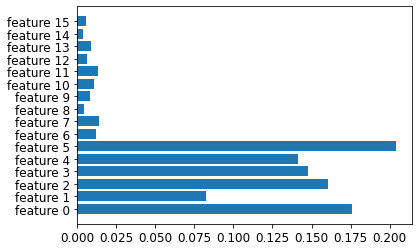

In [37]:
plt.barh(feature_names, importances)

In [91]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


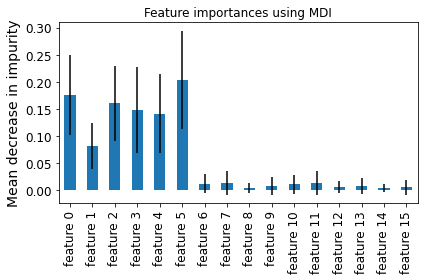

In [92]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [88]:
print("Feature importances:\n{}".format(forest.feature_importances_))

Feature importances:
[0.17602726 0.08231638 0.16047955 0.14780618 0.14150114 0.20390383
 0.01192092 0.01409365 0.00438599 0.00808207 0.0109388  0.01371505
 0.00625365 0.0087351  0.00396767 0.00587275]


AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

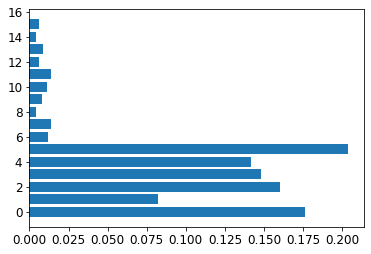

In [93]:
def plot_feature_importances_AD(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_AD(forest)